<a href="https://colab.research.google.com/github/BijoSebastian/grasp_it_repo/blob/main/grasp_planning_vanilla_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Applying Vanilla CNN, VGG-16, ResNet, InceptionNet(ViT if possible)
1. Dataloader:
*   Add all four channels of image into 1 RGBD image.
*   Get position and orientation from csv file and try to add it in one dataloader or figure out some other way.

2. Currently predicting only position and orientation of the gripper:
*  Loss function for orientation to be quaternions is custom made.
*  Total loss= (loss1)X(0.5) + (loss2)X(0.5)

In [33]:
#DataLoader

import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define custom dataset class
class RGBDDataset(Dataset):
    def __init__(self, rgb_dir, depth_dir, transform=None):
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform

        # Get list of filenames in the directories
        self.rgb_files = sorted(os.listdir(rgb_dir))
        self.depth_files = sorted(os.listdir(depth_dir))

        # Ensure the number of RGB and depth images are the same
        assert len(self.rgb_files) == len(self.depth_files), "Number of RGB and depth images do not match"

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        # Load RGB and depth images
        rgb_path = os.path.join(self.rgb_dir, self.rgb_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])
        rgb_img = Image.open(rgb_path).convert('RGB')
        depth_img = Image.open(depth_path)  # Convert to grayscale

        # Apply transformations if specified
        if self.transform:
            rgb_img = self.transform(rgb_img)
            depth_img = self.transform(depth_img)

        # Combine RGB and depth images into RGBD
        rgbd_img = torch.cat((rgb_img, depth_img), dim=0)

        return rgbd_img

# Example usage:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to match input size of CNN
    transforms.ToTensor(),  # Convert images to tensors
])

# Initialize dataset
rgb_dir = '/content/drive/MyDrive/Masters_thesis/Dataset_1/dataset_1(depth=1,2)/rgb'
depth_dir = '/content/drive/MyDrive/Masters_thesis/Dataset_1/dataset_1(depth=1,2)/depth'
dataset = RGBDDataset(rgb_dir, depth_dir, transform=transform)

# Initialize DataLoader
batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
'''
# Assuming you have defined the CNN architecture as CNN_Position_Orientation
model = CNN_Position_Orientation()

# Assuming you have defined loss functions and optimizer
position_criterion = nn.MSELoss()  # Mean Squared Error for position
orientation_criterion = quaternion_loss  # Defined earlier
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (rgbd_images, position_labels, orientation_labels) in enumerate(dataloader):
        # Forward pass
        positions, orientations = model(rgbd_images)

        # Calculate losses
        position_loss = position_criterion(positions, position_labels)
        orientation_loss = orientation_criterion(orientations, orientation_labels)
        total_loss = position_loss + orientation_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()'''
print(f"Length of val dataset loader:{len(dataloader)}")
features_batch=next(iter(dataloader))
features_batch.shape

Length of val dataset loader:143


torch.Size([16, 4, 512, 512])

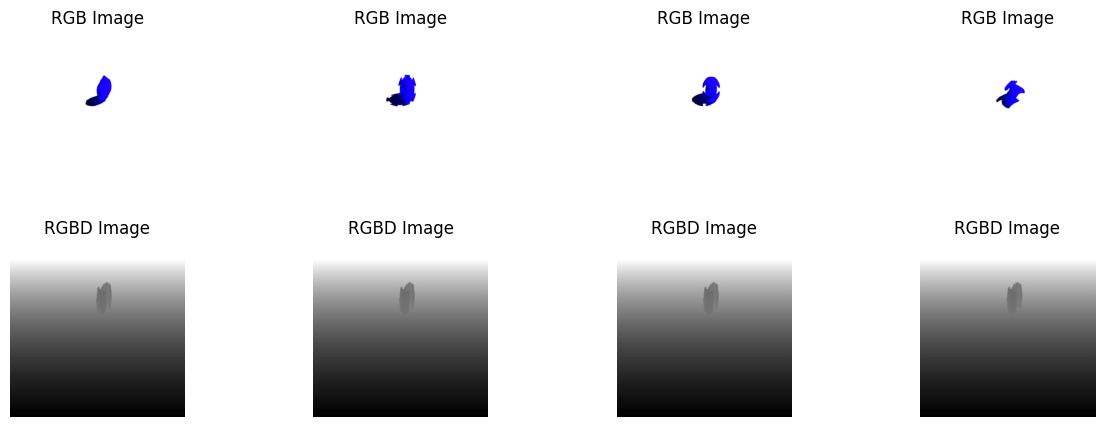

(512, 512)


In [41]:
import matplotlib.pyplot as plt

# Extract a batch of images from the dataloader
images_batch = next(iter(dataloader))

# Define the number of images to visualize
num_images = 4

# Plot the images
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

# Loop through the images in the batch
for i in range(num_images):
    # Extract the RGB and depth images from the batch
    rgb_img = images_batch[i, :3]  # RGB channels
    depth_img = images_batch[i, 3]  # Depth channel

    # Convert tensors to numpy arrays
    rgb_img_np = rgb_img.permute(1, 2, 0).cpu().numpy()  # Permute dimensions and convert to numpy array
    # Normalize depth image for visualization (assuming depth values are between 0 and 1)
    depth_img_np = (depth_img_np - depth_img_np.min()) / (depth_img_np.max() - depth_img_np.min()+1e-8)
    #depth_img_np = depth_img.cpu().numpy()
    # Plot RGB image
    axes[0,i].imshow(rgb_img_np)
    axes[0,i].set_title('RGB Image')
    axes[0,i].axis('off')

    # Plot depth image
    axes[1,i].imshow(depth_img_np, cmap='gray', alpha=1)  # Overlay depth image with transparency
    axes[1,i].set_title('RGBD Image')
    axes[1,i].axis('off')

plt.show()
print(depth_img_np.shape)

In [ ]:
#Helper functions and Quaternion loss function
import torch
import torch.nn as nn

def quaternion_loss(q_actual, q_predicted):
    """
    Compute quaternion loss between actual and predicted quaternions.

    Args:
        q_actual (torch.Tensor): Actual quaternions (batch_size x num_outputs x 4).
        q_predicted (torch.Tensor): Predicted quaternions (batch_size x num_outputs x 4).

    Returns:
        torch.Tensor: Quaternion loss.
    """
    # Compute dot product
    dot_product = torch.sum(q_actual * q_predicted, dim=2)

    # Take absolute difference from 1
    loss = 1 - torch.abs(dot_product)

    return loss.mean()  # Return mean loss over the batch and number of outputs

# Example usage:
# Assuming positions and orientations are tensors of shape (batch_size, num_outputs, 3) and (batch_size, num_outputs, 4) respectively
position_criterion = nn.MSELoss()  # Mean Squared Error for position

# Calculate losses
position_loss = position_criterion(positions, actual_positions)
orientation_loss = quaternion_loss(orientations, actual_orientations)

# Total loss
total_loss = position_loss + orientation_loss

# Backward pass and optimization
optimizer.zero_grad()
total_loss.backward()
optimizer.step()


In [ ]:
#Vanilla CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Position_Orientation(nn.Module):
    def __init__(self, num_outputs=10):
        super(CNN_Position_Orientation, self).__init__()
        self.num_outputs = num_outputs

        # Define convolutional layers for image processing
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Define fully connected layers for position prediction
        self.fc_position1 = nn.Linear(64 * 32 * 32, 512)
        self.fc_position2 = nn.Linear(512, 3 * num_outputs)  # Output 10 sets of 3D positions

        # Define fully connected layers for orientation prediction
        self.fc_orientation1 = nn.Linear(64 * 32 * 32, 512)
        self.fc_orientation2 = nn.Linear(512, 4 * num_outputs)  # Output 10 sets of quaternions

    def forward(self, x):
        # Forward pass through convolutional layers
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 32 * 32)

        # Position prediction
        position = F.relu(self.fc_position1(x))
        position = self.fc_position2(position)
        position = position.view(-1, self.num_outputs, 3)  # Reshape to (batch_size, num_outputs, 3)

        # Orientation prediction
        orientation = F.relu(self.fc_orientation1(x))
        orientation = self.fc_orientation2(orientation)
        orientation = orientation.view(-1, self.num_outputs, 4)  # Reshape to (batch_size, num_outputs, 4)

        return position, orientation

# Example usage:
# Instantiate the model
model = CNN_Position_Orientation(num_outputs=10)

# Assuming rgb_d_image is your input RGBD image tensor of shape (batch_size, channels, height, width)
# Forward pass
positions, orientations = model(rgb_d_image)

# positions shape: (batch_size, num_outputs, 3)
# orientations shape: (batch_size, num_outputs, 4)
